# Attempt 2

In [1]:
from math import pi, sin, cos
import numpy as np
import openmc
import openmc.deplete

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Materials


In [2]:
fuel_materials = [] # note: list of fuel materials
for i in range(0,35): # had to know in advance how many fuel-containing cells.
    fuel = openmc.Material(name='fuel')
    # 40%LEU-60%Th Oxide fuel. 
    fuel.add_nuclide('Th232',0.60611,'ao')
    fuel.add_nuclide('U235',0.019695,'ao')
    fuel.add_nuclide('U238',0.37420,'ao')
    fuel.add_element('O',2.0)
    fuel.set_density('g/cm3',9.7); # check out Blair Bromley reference
    fuel_materials.append(fuel); 
    # I don't like these numbers, but shift focus on structure of input
    # to get the distributed materials.

# Center displacer rod of ZrO2
center = openmc.Material(name='rod')
center.add_element('Zr',1.0)
center.add_element('O',2.0)
center.set_density('g/cm3',4.3)

# Lisowski approximates Zirc-4 with elemental Zr.
# here I will use the PNNL Material compendium composition for Zirc-4
clad = openmc.Material(name='zircaloy')
clad.add_element('O',0.006790)
clad.add_element('Cr',0.001741)
clad.add_element('Fe',0.003242)
clad.add_element('Zr',0.977550)
clad.add_element('Sn',0.010677)
clad.set_density('g/cm3',6.56)

heavy_water = openmc.Material(name='heavy water')
heavy_water.add_nuclide('H2',2.0,'ao')
heavy_water.add_nuclide('O16',1.0,'ao')
heavy_water.add_s_alpha_beta('c_D_in_D2O')
heavy_water.set_density('g/cc',1.1)

In [3]:
# outer radius of fuel and clad
r_fuel_ex = 0.6122 # cm
r_clad_ex = 0.6540 # cm
clad_thickness = r_clad_ex - r_fuel_ex # cm, ignores CO2-filled gap
r_clad = 0.57 # outer radius of Thorium fuel element, given in Bromley paper
r_fuel = r_clad - clad_thickness  #cm. Ah.  I see.  
# use clad thickness from CANDU OpenMC example; apply that to Bromley
# paper example since they do not give clad thickness.

# Outer Radius of the center ZrO2 rod
r_center = 2.4 # cm

# Pressure tube and calendria radii
pressure_tube_ir = 5.2
pressure_tube_or = 5.6
calendria_ir = 6.4
calendria_or = 6.6

ring_radii = np.array([3.0755,4.3305]);

center_radius = np.array([0])

# surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(r=r) for r in 
              (ring_radii[:-1] + ring_radii[1:])/2]

water_cells = []
for i in range(ring_radii.size):
    if i==0:
        water_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        water_region = +radial_surf[i-1]
    else:
        water_region = +radial_surf[i-1] & -radial_surf[i]
    water_cells.append(openmc.Cell(fill=heavy_water,region=water_region))

In [4]:
# also create a water region for the center tube
radial_surf_tube = openmc.ZCylinder(r = r_center + clad_thickness)

water_cell_tube = []
water_region_tube = -radial_surf_tube
water_cell_tube.append(openmc.Cell(fill=heavy_water,region=water_region_tube))

plot_args = {'width':(2*calendria_or,2*calendria_or)}
bundle_universe = openmc.Universe(cells=(water_cells))

# pin_cell universe for each fuel pin, divided between inner and outer pins 
# for ease of iteration when creating fuel pins
pin_universes_inner = []
pin_universes_outer = []

fuel_cells = []

for i in range(0,14):
    surf_fuel = openmc.ZCylinder(r=r_fuel)
    fuel_cell = openmc.Cell(fill=fuel_materials[i],region=-surf_fuel)
    clad_cell = openmc.Cell(fill=clad,region=+surf_fuel)
    
    pin_universes_inner.append(openmc.Universe(cells=(fuel_cell,clad_cell)))
    fuel_cells.append(fuel_cell)
    
    
for i in range(14,35):
    surf_fuel = openmc.ZCylinder(r=r_fuel)
    fuel_cell = openmc.Cell(fill=fuel_materials[i],region=-surf_fuel)
    clad_cell = openmc.Cell(fill=clad,region=+surf_fuel)
    
    pin_universes_outer.append(openmc.Universe(cells=(fuel_cell,clad_cell)))
    fuel_cells.append(fuel_cell)
    
# center rod universe
surf_center = openmc.ZCylinder(r=r_center+clad_thickness)
center_cell = openmc.Cell(fill=center,region=-surf_center)
center_tube_cell = openmc.Cell(fill=clad,region=+surf_center)
center_universe = openmc.Universe(cells=(center_cell,center_tube_cell))

In [5]:
# Center tube creation
num_tubes = [1]
angles = [0]

for i, (r,n,a) in enumerate(zip(center_radius,num_tubes,angles)):
    tube_boundary = openmc.ZCylinder(x0=0,y0=0,r=r_center+clad_thickness)
    water_cells[i].region &= +tube_boundary
    tube = openmc.Cell(fill=center_universe,region=-tube_boundary)
    bundle_universe.add_cell(tube)
    
num_pins = [14,21]
angles = [0,0]

for i,(r,n,a) in enumerate(zip(ring_radii, num_pins,angles)):
    for j in range(n):
        theta = (a+j/n*360.)*pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x,y0=y,r=r_clad)
        water_cells[i].region &= +pin_boundary
        
        if n==14:
            pin=openmc.Cell(fill=pin_universes_inner[j],region=-pin_boundary)
            pin.translation = (x,y,0)
            pin.id = (i+1)*100 + j
            fuel_materials[j].id = pin.id #ID the fuel materials to match the pin ID
        if n == 21:
            pin = openmc.Cell(fill = pin_universes_outer[j],region=-pin_boundary)
            pin.translation = (x,y,0)
            pin.id = (i+1)*100 + j
            fuel_materials[14+j].id = pin.id # ID the fuel materials to match the pin ID
        bundle_universe.add_cell(pin)

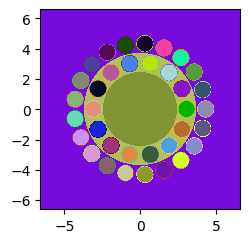

In [6]:
bundle_universe.plot(**plot_args)